In [1]:
import ast
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
test=pd.read_csv('./test.csv')
# train=pd.read_csv('./train.csv')
# dev=pd.read_csv('./dev.csv')
'''executed in 2m 49s'''

'executed in 2m 49s'

In [3]:
len(train),len(test),len(dev)

NameError: name 'train' is not defined

In [3]:
def parse_str_list(df):
    df['text_filtered_per_sentence']=df['text_filtered_per_sentence'].apply(ast.literal_eval)
    df['aspect_filtered_per_sentence']=df['aspect_filtered_per_sentence'].apply(ast.literal_eval)
    
    
parse_str_list(test)
# parse_str_list(train)
# parse_str_list(dev)

'''executed in 2m 24s'''

'executed in 2m 24s'

### language fluency issue

In [3]:
test['text'][330]

"Check-in was quick and Jessie (spelling) was very friendly. She explained everything and went out of her way to check on things for us. The room was nice, but older. The beds were metal frames (weight rating unknown...) with nice mattresses. The headboards....interesting and had reading lights attached. The room was clean.....until day 2 when we had a roach wave hello from the side table. We killed it and forgot about it. Then the last day, we saw more. In all stages of growth, from nymph to full adult. One had even gotten into the fridge. So, we were happy to be leaving. The A/C unit worked well. The pool hours were enforced and the place was quiet during quiet time. Wifi worked good enough. Nice sized TV with an okay line up. Parking was a pain in the butt....cars parking in the truck/trailer parking spaces, making it difficult to maneuver around them to avoid hitting them, then not being able make the turn to get out because of it. Super annoying when cars park where they shouldn't

In [4]:
''.join(ast.literal_eval(test['text_filtered_per_sentence'][330]))

"check - in was quick and jessie ( spelling ) was very friendly .she explained everything and went out of her way to check on things for us .the room was nice , but older .the room was clean ..... until day 2 when we had a roach wave hello from the side table .in all stages of growth , from nymph to full adult .one had even gotten into the fridge .so , we were happy to be leaving .the pool hours were enforced and the place was quiet during quiet time .wifi worked good enough .nice sized tv with an okay line up .parking was a pain in the butt ....cars parking in the truck / trailer parking spaces , making it difficult to maneuver around them to avoid hitting them , then not being able make the turn to get out because of it .super annoying when cars park where they should n't !need to know : fridge / microwave in room truck / trailer parking ( tight )"

In [6]:

test['text'][201]

test['hotel_url'][201]


'Hotel_Review-g60724-d267781-Reviews-Red_Cliffs_Lodge-Moab_Utah.html'

### build the mean of single aspect rating

In [4]:
def build_asp_rating(split):
    aspect_rating=split.replace(-1,np.nan).groupby('hotel_url')[["service","cleanliness","value","location","rooms"]].mean()

    aspect_rating=aspect_rating.rename(columns={'service':'aspect 0 ','cleanliness':'aspect 1 ',\
                                  'value':'aspect 2 ','location':'aspect 3 ','rooms':'aspect 4 '}).reset_index()


    aspect_rating=pd.melt(aspect_rating, id_vars='hotel_url', value_vars=['aspect 0 ','aspect 1 ','aspect 2 '\
                                                              ,'aspect 3 ','aspect 4 ',])

    aspect_rating['hotel_url_new']=aspect_rating['variable']+aspect_rating['hotel_url']
    aspect_rating=aspect_rating[['hotel_url_new','value']].rename(columns={'hotel_url_new':'hotel_url'})

    aspect_rating=aspect_rating.replace(np.nan,-1)
    aspect_rating.rename(columns={'value':'rating'},inplace=True)
    return aspect_rating


In [5]:
test_asp_rating=build_asp_rating(test)
# train_asp_rating=build_asp_rating(train)
# dev_asp_rating=build_asp_rating(dev)

### build RSAR

In [6]:
def groupByAspect(split):
    split_sentence=split[['hotel_url','text','text_filtered_per_sentence']].explode('text_filtered_per_sentence')
    split_aspect=split[['hotel_url','text','aspect_filtered_per_sentence']].explode('aspect_filtered_per_sentence')
    split_sentence.reset_index(drop=True,inplace=True)
    split_aspect.reset_index(drop=True,inplace=True)
    split_exploded=split_aspect.join(split_sentence[['text_filtered_per_sentence']])
    
    grouped=pd.DataFrame(split_exploded.groupby(['hotel_url','aspect_filtered_per_sentence'])['text_filtered_per_sentence'].apply(list))
    grouped.reset_index(inplace=True)
    grouped['text_filtered_per_sentence']=grouped['text_filtered_per_sentence'].apply(lambda data: [data[x:x+5] for x in range(0, len(data), 5)])
    grouped.head()
    
    grouped=grouped.explode('text_filtered_per_sentence').reset_index()
    grouped['text']=grouped['text_filtered_per_sentence'].apply(lambda x:''.join(x))
    grouped=grouped.rename(columns={'hotel_url':'hotel_url_original'})
    grouped['hotel_url']=grouped['hotel_url_original']
    grouped=grouped[['index', 'hotel_url', 'aspect_filtered_per_sentence',
           'text_filtered_per_sentence', 'text','hotel_url_original']]
    
    grouped['hotel_url']='aspect '+grouped['aspect_filtered_per_sentence'].apply(str)+' '+grouped['hotel_url_original']
    return grouped

In [7]:
"executed in 14m 6s"

test=groupByAspect(test)
# train=groupByAspect(train)
# dev=groupByAspect(dev)
test.head(2)

,index,hotel_url,aspect_filtered_per_sentence,text_filtered_per_sentence,text,hotel_url_original
0,0,aspect 0 Hotel_Review-g10006284-d1083311-Revie...,0,"[beware of the food service , the restaurant t...","beware of the food service , the restaurant th...",Hotel_Review-g10006284-d1083311-Reviews-The_Re...
1,1,aspect 1 Hotel_Review-g10006284-d1083311-Revie...,1,"[the service was outstanding , the room was ve...","the service was outstanding , the room was ver...",Hotel_Review-g10006284-d1083311-Reviews-The_Re...


### merge asp rating and RSAR

In [8]:
#merge rating dataframe with RSAR review dataframe
test=pd.merge(test,test_asp_rating,left_on='hotel_url',right_on='hotel_url',how='left')
#train=pd.merge(train,train_asp_rating,left_on='hotel_url',right_on='hotel_url',how='left')
#dev=pd.merge(dev,dev_asp_rating,left_on='hotel_url',right_on='hotel_url',how='left')

In [12]:
# drop rows which rating are missing,round float to 1-5 integers
test=test[test['rating']!=-1]
test['rating']=test['rating'].apply(np.round)

train=train[train['rating']!=-1]
train['rating']=train['rating'].apply(np.round)

dev=dev[dev['rating']!=-1]
dev['rating']=dev['rating'].apply(np.round)

In [11]:
test=test[test['hotel_url'].str.startswith('aspect 0')]

In [39]:
# no null value in rating 
test_final[test_final['rating'].isna()]

,index,hotel_url,aspect_filtered_per_sentence,text_filtered_per_sentence,text,hotel_url_original,value


## data visualization

In [35]:
# check the number of business 

def check_business_no(data):
    return len(set(data['hotel_url']))

check_business_no(train),check_business_no(test),check_business_no(dev)

(38897, 37538, 36681)

In [43]:
train['text'].apply(len).sort_values()

1540616        9
588528        14
1579838       16
1646008       17
588531        19
           ...  
972406     32683
1118628    35119
509202     40224
509208     58889
509206     63343
Name: text, Length: 1749157, dtype: int64

__Distribution of review lenth:__  ⬇️

In [25]:
len(test)

416982

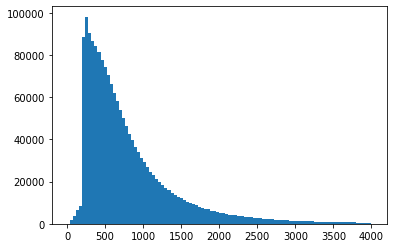

In [55]:

plt.hist(train['text'].apply(len),bins=100,range=(0,4000));

__Distribution of number of reviews associated to hotel:__  ⬇️

In [61]:
n_review_to_hotel=train.groupby('hotel_url')['text'].apply(list).apply(len)

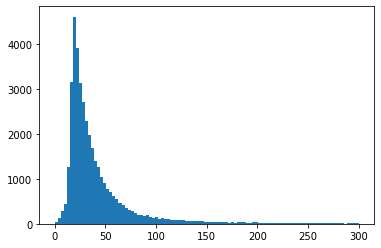

In [65]:
plt.hist(n_review_to_hotel,bins=100,range=(0,300));

## to_json

In [18]:
"executed in 51.6s"
tot=pd.concat([dev,test,train])

"executed in 1m 1.82s"
df=tot.sort_values('hotel_url')[['hotel_url','text','rating']]
#df=tot.sort_values('hotel_url')[['hotel_url','rating']]

### build the mean of single aspect rating

In [11]:
aspect_rating=test.replace(-1,np.nan).groupby('hotel_url')[["service","cleanliness","value","location","rooms"]].mean()

KeyError: "Columns not found: 'value', 'rooms', 'service', 'location', 'cleanliness'"

In [16]:
aspect_rating=aspect_rating.rename(columns={'service':'aspect 0 ','cleanliness':'aspect 1 ',\
                              'value':'aspect 2 ','location':'aspect 3 ','rooms':'aspect 4 '}).reset_index()


In [17]:
aspect_rating=pd.melt(aspect_rating, id_vars='hotel_url', value_vars=['aspect 0 ','aspect 1 ','aspect 2 '\
                                                          ,'aspect 3 ','aspect 4 ',])

In [18]:
aspect_rating['hotel_url_new']=aspect_rating['variable']+aspect_rating['hotel_url']
aspect_rating=aspect_rating[['hotel_url_new','value']].rename(columns={'hotel_url_new':'hotel_url'})

aspect_rating

In [20]:
"executed in 30.0"
df.to_json('../review.json',orient='records')

## Mask
Five aspect:

0.service                         
1.cleanliness                                                
2.value                           
3.location  
4.room



 0-4 in this order

Service   Cleanliness Value  Location Room 

In [6]:
import ast

In [7]:
test['text_filtered_per_sentence'][1]

["unfortunately the accommodation does n't come up to standard !",
 'the free shuttle from the airport is great , which s the main reason we chose the avra and rafina .',
 'there is really no other competition in rafina as far as hotel accommodation is concerned-',
 "there 's a few places with rooms , and some studios",
 'the hotel is a bit run down , but is due for a makeover soon , which will make it a fantastic place to stay with its proximity to the port and many good restaurants nearby .',
 "if you do n't mind a few frayed carpets and a knocked about room you wo n't have any complaints ."]

In [8]:
test['text'][1]

"Unfortunately the accommodation doesn't come up to standard! The free shuttle from the airport is great, which s the main reason we chose The Avra and Rafina. There is really no other competition in Rafina as far as hotel accommodation is concerned- there's a few places with rooms, and some studios but that's about it. The hotel is a bit run down, but is due for a makeover soon, which will make it a fantastic place to stay with its proximity to the port and many good restaurants nearby. If you don't mind a few frayed carpets and a knocked about room you won't have any complaints."

In [9]:
test['text_filtered_per_sentence'].apply(ast.literal_eval).apply(len)

ValueError: malformed node or string: ['clean , cheap if you book 10 days in advance and comfortable .', 'only a 15 minute walk to the top of the town with many choices for breakfast and evening meals .', 'a very good base for exploring he local area , with ross on wye , hay on wye and brecon a short drive away .']

In [ ]:
test['text_filtered_per_sentence'][3]

In [ ]:
test['text'][3]

In [ ]:
test['aspect_filtered_per_sentence']

In [ ]:
test['text_filtered_per_relation'][0]

In [ ]:
test['text'][1]

In [ ]:
test['aspect_filtered_per_relation']

In [19]:
test['rel_filtered_per_relation']

0         ['15 minute walk  -(to)-> top', 'many choices ...
1         ['free shuttle  -(from)-> airport', 'great  -(...
2         ['lovely  -(amod)-> place', 'lovely  -(acomp-n...
3         ['very comfortable  -(acomp-nsubj)-> room', 'l...
4         ['good  -(amod)-> rate', 'clean  -(acomp-nsubj...
                                ...                        
257181    ['excellent  -(acomp-nsubj)-> breakfast', 'exc...
257182    ['excellent  -(amod)-> hotel', 'great  -(amod)...
257183    ['great  -(amod)-> place', 'next stay  -(in)->...
257184    ['nice  -(amod)-> lobby', 'nice  -(amod)-> sta...
257185    ['great  -(amod)-> place', 'large  -(amod)-> c...
Name: rel_filtered_per_relation, Length: 257186, dtype: object

### get rid of empy reviews

In [14]:
test['aspect_filtered_per_sentence'].apply(len)

0          9
1         18
2         18
3         21
4         15
          ..
257181    12
257182     9
257183    12
257184    15
257185    12
Name: aspect_filtered_per_sentence, Length: 257186, dtype: int64

In [16]:
"""There is no review with 0 mask"""
test['text'][test['aspect_filtered_per_sentence'].apply(len)<=1]

Series([], Name: text, dtype: object)

### To remove overlap in masks 

In [18]:
#original aspect
original_aspect=test['text_filtered_per_sentence'].apply(ast.literal_eval).apply(set).apply(len)



In [19]:
#original aspect
original_aspect2=test['text_filtered_per_sentence'].apply(ast.literal_eval).apply(len)




In [20]:
sum(original_aspect2!=original_aspect)

62

In [23]:
'''Example of one overlapped mask'''
test['text_filtered_per_sentence'][original_aspect2!=original_aspect].iloc[0]

'[\'this is a really nice hotel with great views of the arch .\', \'the guy who brought our luggage to the room was so nice , and helpful .\', "our room was kind of small , but served it \'s purpose for the 2 night stay , and we had a wonderful view of the arch .", \'the bed was comfortable , the linens were clean , and the we had plenty of clean towels .\', \'hyatt st louis\', \'this is a really nice hotel with great views of the arch .\', \'the guy who brought our luggage to the room was so nice , and helpful .\', "our room was kind of small , but served it \'s purpose for the 2 night stay , and we had a wonderful view of the arch .", \'the bed was comfortable , the linens were clean , and the we had plenty of clean towels .\', \'the shower had mold in the corners , and the tile grout needed cleaning .\', \'the bathroom vent also needs to be cleaned .\']'

<span style="color: red;">'[\'this is a really nice hotel with great views of the arch .\', \'the guy who brought our luggage to the room was so nice , and helpful .\', "our room was kind of small , but served it \'s purpose for the 2 night stay , and we had a wonderful view of the arch .", \'the bed was comfortable , the linens were clean , and the we had plenty of clean towels .\',</span>. \'hyatt st louis\', <span style="color:blue">\'this is a really nice hotel with great views of the arch .\', \'the guy who brought our luggage to the room was so nice , and helpful .\', "our room was kind of small , but served it \'s purpose for the 2 night stay , and we had a wonderful view of the arch .", \'the bed was comfortable , the linens were clean , and the we had plenty of clean towels .\',</span> \'the shower had mold in the corners , and the tile grout needed cleaning .\', \'the bathroom vent also needs to be cleaned .\']'

In [24]:
'''62 overlapped mask''';

### Relation between original aspect and filtered aspect 

In [25]:
#original aspect
original_aspect=test['aspect_filtered_per_sentence'].apply(ast.literal_eval).apply(set)


In [22]:
#filtered aspect
filtered_aspect=test['aspect_filtered_per_relation'].apply(ast.literal_eval).apply(set)




In [32]:
equal_proportion=sum(filtered_aspect==original_aspect)/len(filtered_aspect )
print('Percentage of equal coverage of aspects={}'.format(equal_proportion))

Percentage of equal coverage of aspects=0.34886813434634856


In [35]:
equal_proportion=sum(filtered_aspect.apply(len)>original_aspect.apply(len))/len(filtered_aspect )
print('filtered cover more than original aspects={}'.format(equal_proportion))

filtered cover more than original aspects=0.31661132410006765


In [36]:
equal_proportion=sum(filtered_aspect.apply(len)<original_aspect.apply(len))/len(filtered_aspect )
print('Original cover more than filtered aspects={}'.format(equal_proportion))

Original cover more than filtered aspects=0.23458508627996857


### to_json(filtered by relation)

In [7]:
test_filtered=test.copy()
test_filtered['text_filtered_per_sentence']=test_filtered['text_filtered_per_sentence'].apply(ast.literal_eval).\
apply(lambda x:"\\".join(x) )





In [ ]:
tot=pd.concat([dev,test,train])
df=tot.sort_values('hotel_url')[['hotel_url','text_filtered_per_relation_grouped','rating']]
df.to_json('../review_filtered.json',orient='records')

## subword encoder

In [3]:
df=test

In [4]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [5]:
# Build
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    df['text'].to_list(), target_vocab_size=32000)

KeyboardInterrupt: 

In [10]:
import pickle
with open('../processed/subwordenc_32000_secondpass.pkl', 'wb') as file:
    pickle.dump(encoder, file, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
encoder.encode('hhhhhdsfhladfhklsahhh')

[22022, 19355, 7888, 31880, 10213, 7054, 31880, 17395, 6183, 6904, 19355]